<a href="https://colab.research.google.com/github/gyyang/neurogym/blob/master/examples/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## TOML-based configuration demo

This notebook demonstrates how to instantiate an environment and a `Monitor` wrapper using a TOML-based configuration. Except for that, the rest of the pipeline in this notebook is identical to the one in `demo.ipynb`.

We will train a network on the `GoNogo-v0` task using the A2C algorithm [Mnih et al. 2016](https://arxiv.org/abs/1602.01783) implemented in the [stable-baselines3](https://stable-baselines3.readthedocs.io/en/master/) toolbox, and plot the results.

You can easily change the code to train a network on any other available task or using a different algorithm (e.g. ACER, PPO2).

### Installation on google colab

Uncomment and execute cell below if running on google colab.


In [1]:
# # Install gymnasium
# ! pip install gymnasium
# # Install neurogym
# ! git clone https://github.com/neurogym/neurogym.git
# %cd neurogym/
# ! pip install -e .
# # Install stable-baselines3
# ! pip install stable-baselines3

### Explore tasks


In [2]:
import warnings
warnings.filterwarnings('ignore')
import gymnasium as gym
import neurogym as ngym
from neurogym.utils import info, plotting
info.all_tasks()

AntiReach-v0
Bandit-v0
ContextDecisionMaking-v0
DawTwoStep-v0
DelayComparison-v0
DelayMatchCategory-v0
DelayMatchSample-v0
DelayMatchSampleDistractor1D-v0
DelayPairedAssociation-v0
DualDelayMatchSample-v0
EconomicDecisionMaking-v0
GoNogo-v0
HierarchicalReasoning-v0
IntervalDiscrimination-v0
MotorTiming-v0
MultiSensoryIntegration-v0
Null-v0
OneTwoThreeGo-v0
PerceptualDecisionMaking-v0
PerceptualDecisionMakingDelayResponse-v0
PostDecisionWager-v0
ProbabilisticReasoning-v0
PulseDecisionMaking-v0
Reaching1D-v0
Reaching1DWithSelfDistraction-v0
ReachingDelayResponse-v0
ReadySetGo-v0
SingleContextDecisionMaking-v0
psychopy.RandomDotMotion-v0
psychopy.SpatialSuppressMotion-v0
psychopy.VisualSearch-v0


### Visualize a single task


<OrderEnforcing<PassiveEnvChecker<GoNogo>>>


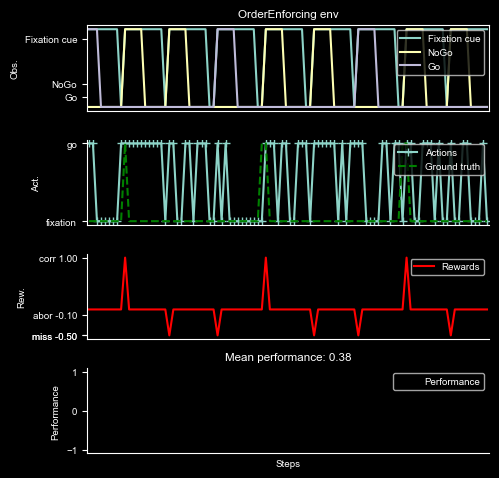

In [3]:
task = 'GoNogo-v0'
env = gym.make(task)
print(env)
fig = plotting.plot_env(
    env,
    num_steps=100,
    # def_act=0,
    ob_traces=['Fixation cue', 'NoGo', 'Go'],
    # fig_kwargs={'figsize': (12, 12)}
    )

### Explore wrappers


In [4]:
info.all_wrappers()

Monitor-v0
Noise-v0
PassAction-v0
PassReward-v0
RandomGroundTruth-v0
ReactionTime-v0
ScheduleAttr-v0
ScheduleEnvs-v0
SideBias-v0
TrialHistoryV2-v0


In [5]:
info.info_wrapper('TrialHistoryV2-v0', show_code=True)

'### TrialHistoryV2-v0\n\nLogic: Missing description\n\n\n#### Source code #### \n\nclass TrialHistoryV2(TrialWrapper):\n    """Change ground truth probability based on previous outcome.\n\n    Args:\n        probs: matrix of probabilities of the current choice conditioned\n            on the previous. Shape, num-choices x num-choices\n    """\n\n    def __init__(self, env, probs=None) -> None:\n        super().__init__(env)\n        try:\n            self.n_ch = len(self.choices)  # max num of choices\n        except AttributeError as e:\n            msg = "TrialHistory requires task to have attribute choices."\n            raise AttributeError(msg) from e\n        if probs is None:\n            probs = np.ones((self.n_ch, self.n_ch)) / self.n_ch  # uniform\n        self.probs = probs\n        if self.probs.shape != (self.n_ch, self.n_ch):\n            msg = f"{self.probs.shape=} should be {self.n_ch, self.n_ch=}."\n            raise ValueError(msg)\n        self.prev_trial = self.rng

### Train a network


In [6]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from neurogym.wrappers import monitor, TrialHistoryV2
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C  # ACER, PPO2
# task paremters
timing = {'fixation': ('constant', 300),
          'stimulus': ('constant', 700),
          'decision': ('constant', 300)}
kwargs = {'dt': 100, 'timing': timing}
# wrapper parameters
n_ch = 2
p = 0.8
num_blocks = 2
probs = np.array([[p, 1-p], [1-p, p]])  # repeating block

# Build the task
env = gym.make(task, **kwargs)

# Apply the wrapper.
# Here, we use a configuration file to load the parameters.
env = TrialHistoryV2(env, probs=probs)
env = monitor.Monitor(env, conf="./conf.demo.toml")

Neurogym | 2025-02-27@17:35:32 | Logger configured.


In [8]:
# the env is now wrapped automatically when passing it to the constructor
model = A2C("MlpPolicy", env, verbose=1, policy_kwargs={'net_arch': [64, 64]})
model.learn(total_timesteps=env.conf.env.steps)
env.close()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| time/                 |          |
|    fps                | 1217     |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.492   |
|    explained_variance | 0.304    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 0.00805  |
|    value_loss         | 6.28e-05 |
------------------------------------
--------------------
Number of steps:  600.0
Average reward:  -0.025
--------------------
------------------------------------
| time/                 |          |
|    fps                | 1001     |
|    iterations         | 200      |
|    time_elapsed       | 0        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.4     |
| 

### Visualize results


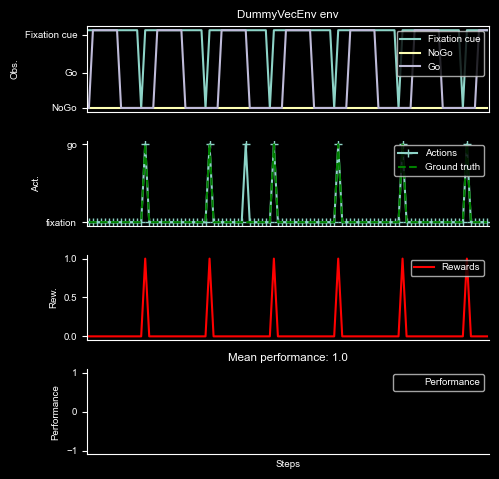

In [9]:
import numpy as np
import matplotlib.pyplot as plt
# Create task
env = gym.make(task, **kwargs)
# Apply the wrapper
env = TrialHistoryV2(env, probs=probs)
env = DummyVecEnv([lambda: env])
fig = plotting.plot_env(
    env,
    num_steps=100,
    # def_act=0,
    ob_traces=['Fixation cue', 'NoGo', 'Go'],
    # fig_kwargs={'figsize': (12, 12)},
    model=model)